In [84]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_excel("initial_data/nipt_data.xlsx")
print(df.head())

   序号  孕妇代码  年龄     身高    体重                 末次月经 IVF妊娠      检测日期  检测抽血次数  \
0   1  A001  31  160.0  72.0  2023-02-01 00:00:00  自然受孕  20230429       1   
1   2  A001  31  160.0  73.0  2023-02-01 00:00:00  自然受孕  20230531       2   
2   3  A001  31  160.0  73.0  2023-02-01 00:00:00  自然受孕  20230625       3   
3   4  A001  31  160.0  74.0  2023-02-01 00:00:00  自然受孕  20230716       4   
4   5  A002  32  149.0  74.0  2023-11-09 00:00:00  自然受孕  20240219       1   

    检测孕周  ...    Y染色体浓度    X染色体浓度  13号染色体的GC含量  18号染色体的GC含量  21号染色体的GC含量  \
0  11w+6  ...  0.025936  0.038061     0.377069     0.389803     0.399399   
1  15w+6  ...  0.034887  0.059572     0.371542     0.384771     0.391706   
2  20w+1  ...  0.066171  0.075995     0.377449     0.390582     0.399480   
3  22w+6  ...  0.061192  0.052305     0.375613     0.389251     0.397212   
4  13w+6  ...  0.059230  0.059708     0.380260     0.393618     0.404868   

   被过滤掉读段数的比例  染色体的非整倍体  怀孕次数  生产次数  胎儿是否健康  
0    0.027484       NaN     1     

In [85]:
#过滤y染色体缺失行
df = df[df['Y染色体浓度'].notna()].copy()

def convert_ga_to_decimal(ga_str):
    """将“Xw+Y”格式转换为小数周（如11w+6 = 11 + 6/7 ≈ 11.86周）"""
    if pd.isna(ga_str):
        return np.nan
    # 拆分“周”和“天”部分，适配实际数据格式
    if 'w+' in str(ga_str):
        w_part, d_part = str(ga_str).split('w+')
    else:
        return np.nan  # 排除格式异常的孕周（如纯数字）
    try:
        return int(w_part) + int(d_part) / 7
    except (ValueError, IndexError):
        return np.nan

# 转换孕周并筛选10-25周样本
df['小数孕周'] = df['检测孕周'].apply(convert_ga_to_decimal)
df = df[(df['小数孕周'] >= 10) & (df['小数孕周'] <= 25)]

# 4. 测序质量筛选（C题.pdf附录1：GC含量正常范围40%~60%，对应真实列名“GC含量”（列16））
# 注意：数据中GC含量可能以小数形式呈现（如0.377069=37.7%），需先转换为百分比
df['GC含量_百分比'] = df['GC含量'] * 100
df = df[(df['GC含量_百分比'] >= 40) & (df['GC含量_百分比'] <= 60)]

# 5. 剔除Y染色体浓度异常值（C题.pdf4：男胎Y浓度达标值≥4%，数据中为小数（如0.025936=2.59%），合理范围0~15%）
df['Y染色体浓度_百分比'] = df['Y染色体浓度'] * 100
df = df[(df['Y染色体浓度_百分比'] >= 0) & (df['Y染色体浓度_百分比'] <= 15)]

# 6. 输出筛选结果（验证数据有效性）
print("=== 数据筛选结果 ===")
print(f"原始数据总样本数：{len(df)}")
print(f"男胎样本数（Y染色体浓度非空）：{len(df[df['Y染色体浓度'].notna()])}")
print(f"10-25周+正常GC的有效男胎样本数：{len(df)}")

# 7. 查看核心变量描述统计（贴合C题.pdf问题1的分析对象）
print("\n=== 核心变量描述统计（有效样本） ===")
core_vars = df[['Y染色体浓度_百分比', '小数孕周', '孕妇BMI']].rename(columns={
    'Y染色体浓度_百分比': 'Y染色体浓度(%)',
    '小数孕周': '孕周（小数）',
    '孕妇BMI': 'BMI'
})
print(core_vars.describe())

# 标记同一孕妇的多次检测（C题.pdf6：存在多次采血检测，对应真实列名“孕妇代码”（列2））
df['检测次数'] = df.groupby('孕妇代码')['检测日期'].cumcount() + 1  # 按检测日期排序标记次数

# 查看重复检测示例（以孕妇A001为例，匹配你提供的前3行数据）
print("\n=== 同一孕妇多次检测示例（孕妇A001） ===")
a001_data = df[df['孕妇代码'] == 'A001'][
    ['孕妇代码', '检测次数', '检测孕周', '小数孕周', 'Y染色体浓度_百分比', '孕妇BMI']
].sort_values('检测次数')

print(a001_data)

=== 数据筛选结果 ===
原始数据总样本数：519
男胎样本数（Y染色体浓度非空）：519
10-25周+正常GC的有效男胎样本数：519

=== 核心变量描述统计（有效样本） ===
        Y染色体浓度(%)      孕周（小数）         BMI
count  519.000000  519.000000  519.000000
mean     7.574064   16.120286   32.304640
std      2.916116    3.642887    2.747084
min      1.000389   11.000000   26.619343
25%      5.219353   13.142857   30.370302
50%      7.630164   15.571429   32.017138
75%      9.839118   17.857143   33.920238
max     14.825457   24.857143   46.875000

=== 同一孕妇多次检测示例（孕妇A001） ===
Empty DataFrame
Columns: [孕妇代码, 检测次数, 检测孕周, 小数孕周, Y染色体浓度_百分比, 孕妇BMI]
Index: []


In [86]:
BMI_info=df['孕妇BMI']
Y_info=df['Y染色体浓度']

def convert_ga_to_decimal(ga_str):
    """将“Xw+Y”格式转换为小数周（如11w+6 = 11 + 6/7 ≈ 11.86周）"""
    if pd.isna(ga_str):
        return np.nan
    if 'w+' in str(ga_str):
        w_part, d_part = str(ga_str).split('w+')
    else:
        return np.nan
    try:
        return int(w_part) + int(d_part) / 7
    except (ValueError, IndexError):
        return np.nan
    

df['小数孕周'] = df['检测孕周'].apply(convert_ga_to_decimal)
df = df[(df['小数孕周'] >= 10) & (df['小数孕周'] <= 25)]

gestational_weeks_info=df['小数孕周']

In [87]:
height_info = df['身高']
weight_info = df['体重']
BMI_calculate = weight_info / (height_info / 100) ** 2
error=(BMI_calculate - BMI_info)/BMI_calculate

threshold = 0.1
mask = error.abs() > threshold

print(df[mask])

Empty DataFrame
Columns: [序号, 孕妇代码, 年龄, 身高, 体重, 末次月经, IVF妊娠, 检测日期, 检测抽血次数, 检测孕周, 孕妇BMI, 原始读段数, 在参考基因组上比对的比例, 重复读段的比例, 唯一比对的读段数  , GC含量, 13号染色体的Z值, 18号染色体的Z值, 21号染色体的Z值, X染色体的Z值, Y染色体的Z值, Y染色体浓度, X染色体浓度, 13号染色体的GC含量, 18号染色体的GC含量, 21号染色体的GC含量, 被过滤掉读段数的比例, 染色体的非整倍体, 怀孕次数, 生产次数, 胎儿是否健康, 小数孕周, GC含量_百分比, Y染色体浓度_百分比, 检测次数]
Index: []

[0 rows x 35 columns]


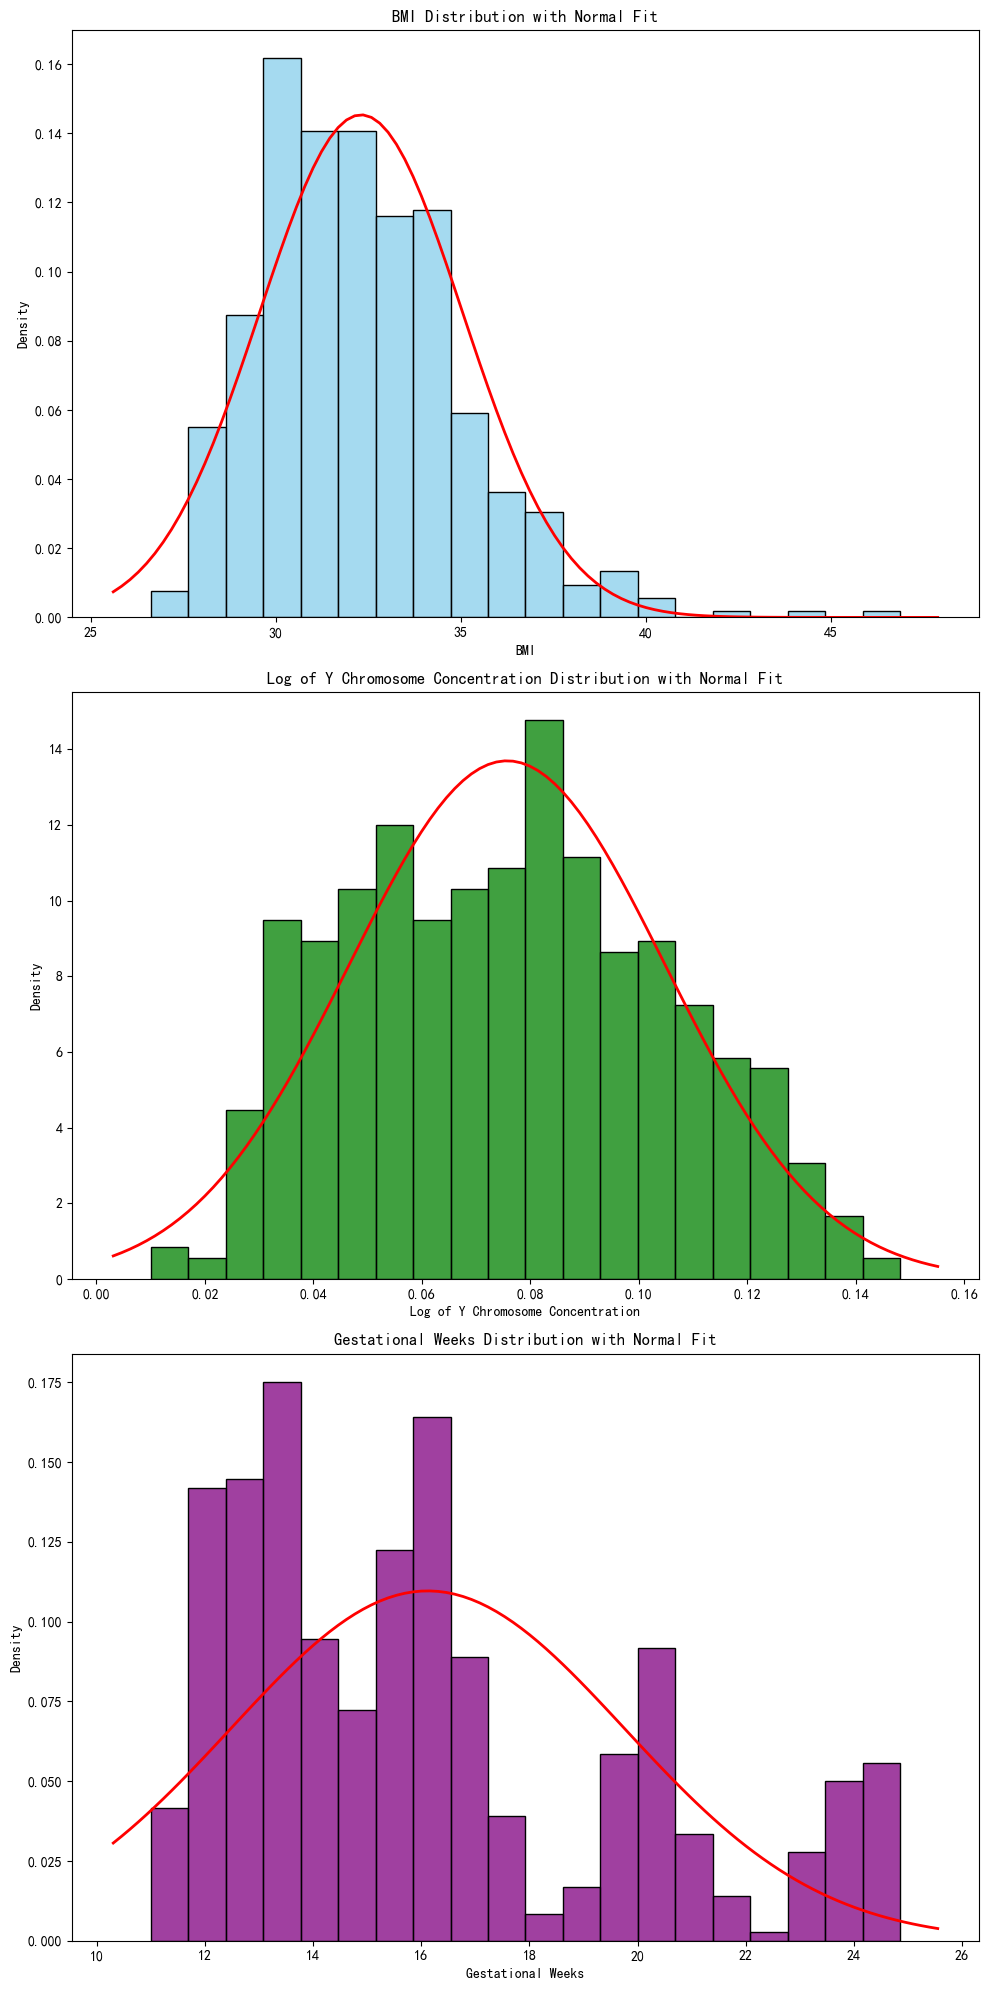

In [88]:
# 设置子图的布局
fig, axes = plt.subplots(3, 1, figsize=(10, 20))

sns.histplot(BMI_info, bins=20, kde=False, color='skyblue', stat='density', ax=axes[0])
mu_bmi, std_bmi = stats.norm.fit(BMI_info)
xmin_bmi, xmax_bmi = axes[0].get_xlim()
x_bmi = np.linspace(xmin_bmi, xmax_bmi, 100)
p_bmi = stats.norm.pdf(x_bmi, mu_bmi, std_bmi)
axes[0].plot(x_bmi, p_bmi, 'r', linewidth=2)
axes[0].set_title('BMI Distribution with Normal Fit')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Density')
# 绘制Y染色体浓度对数的直方图及正态分布拟合
sns.histplot(Y_info, bins=20, kde=False, color='green', stat='density', ax=axes[1])
mu_y, std_y = stats.norm.fit(Y_info)
xmin_y, xmax_y = axes[1].get_xlim()
x_y = np.linspace(xmin_y, xmax_y, 100)
p_y = stats.norm.pdf(x_y, mu_y, std_y)
axes[1].plot(x_y, p_y, 'r', linewidth=2)
axes[1].set_title('Log of Y Chromosome Concentration Distribution with Normal Fit')
axes[1].set_xlabel('Log of Y Chromosome Concentration')
axes[1].set_ylabel('Density')
# 绘制检测孕周的直方图及正态分布拟合
sns.histplot(gestational_weeks_info, bins=20, kde=False, color='purple', stat='density', ax=axes[2])
mu_gw, std_gw = stats.norm.fit(gestational_weeks_info)
xmin_gw, xmax_gw = axes[2].get_xlim()
x_gw = np.linspace(xmin_gw, xmax_gw, 100)
p_gw = stats.norm.pdf(x_gw, mu_gw, std_gw)
axes[2].plot(x_gw, p_gw, 'r', linewidth=2)
axes[2].set_title('Gestational Weeks Distribution with Normal Fit')
axes[2].set_xlabel('Gestational Weeks')
axes[2].set_ylabel('Density')
# 调整子图之间的间距
plt.tight_layout()
plt.show()

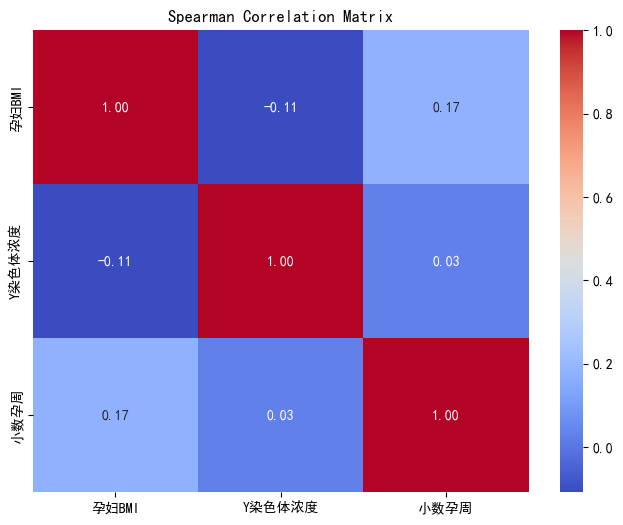

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 选择相关的列并强制数据为数值型
data = df[['孕妇BMI', 'Y染色体浓度', '小数孕周']]
data = data.apply(pd.to_numeric, errors='coerce')

# 计算 Spearman 等级相关性矩阵
spearman_corr_matrix = data.corr(method='spearman')

# 绘制 Spearman 相关性矩阵的热图
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation Matrix')
plt.show()

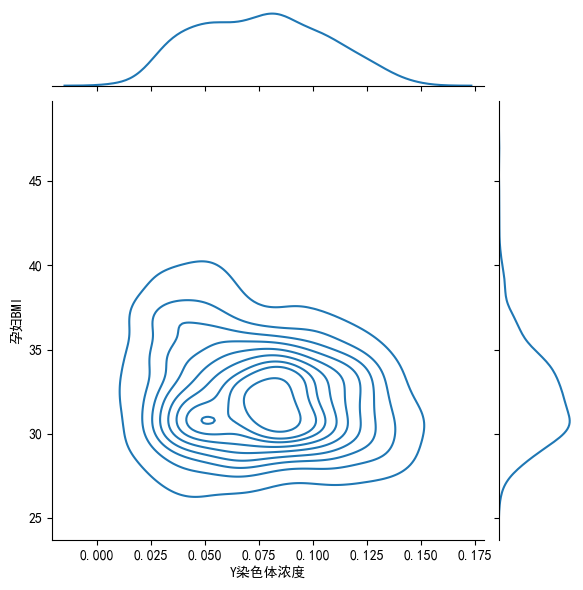

In [90]:
import seaborn as sns
sns.jointplot(x=Y_info, y=BMI_info, kind='kde')
plt.show()

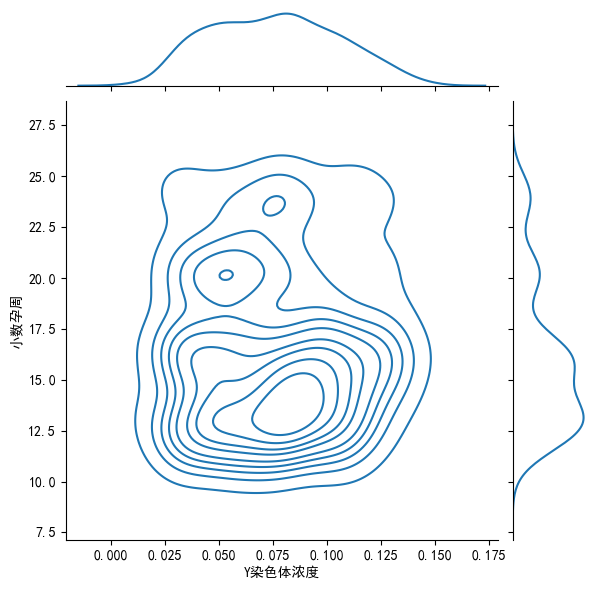

In [91]:
import seaborn as sns
sns.jointplot(x=Y_info, y=gestational_weeks_info, kind='kde')
plt.show()

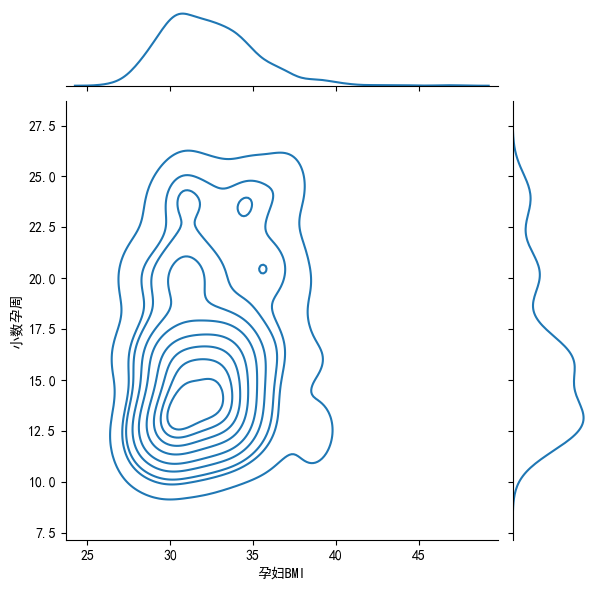

In [92]:
import seaborn as sns
sns.jointplot(x=BMI_info, y=gestational_weeks_info, kind='kde')
plt.show()

In [93]:
filtered = df.groupby('孕妇代码').apply(lambda x: x.sample(n=1)).reset_index(drop=True)
print(filtered)

       序号  孕妇代码  年龄     身高     体重                 末次月经 IVF妊娠  \
0       5  A002  32  149.0  74.00  2023-11-09 00:00:00  自然受孕   
1      14  A003  35  160.0  81.62  2023-02-20 00:00:00  自然受孕   
2      19  A004  26  158.0  72.80  2023-06-11 00:00:00  自然受孕   
3      21  A005  30  150.0  69.40  2023-04-15 00:00:00  自然受孕   
4      24  A006  31  153.0  84.00  2023-07-05 00:00:00  自然受孕   
..    ...   ...  ..    ...    ...                  ...   ...   
226  1063  A263  30  157.0  72.34           2022-12-28  自然受孕   
227  1069  A264  30  171.0  96.83           2022-12-27  自然受孕   
228  1074  A265  32  168.0  97.84           2022-12-28  自然受孕   
229  1076  A266  30  159.0  81.63           2022-12-29  自然受孕   
230  1080  A267  28  155.0  74.06           2023-02-25  自然受孕   

                    检测日期  检测抽血次数   检测孕周  ...  21号染色体的GC含量  被过滤掉读段数的比例  \
0               20240219       1  13w+6  ...     0.404868    0.024212   
1               20230710       3  20w+2  ...     0.405542    0.022290   
2           

C:\Users\xia\AppData\Local\Temp\ipykernel_40152\3436655873.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered = df.groupby('孕妇代码').apply(lambda x: x.sample(n=1)).reset_index(drop=True)


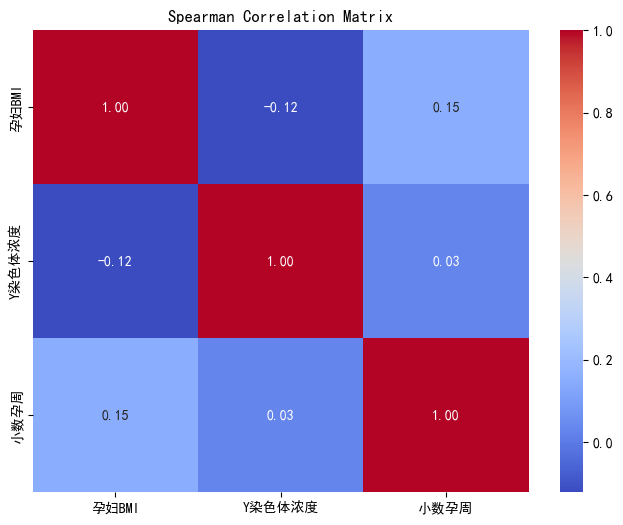

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# 确保数据是数值类型
data = filtered[['孕妇BMI', 'Y染色体浓度', '小数孕周']]
data = data.apply(pd.to_numeric, errors='coerce')
# 计算Spearman等级相关性矩阵
spearman_corr_matrix = data.corr(method='spearman')
# 绘制Spearman相关性矩阵的热图
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation Matrix')
plt.show()

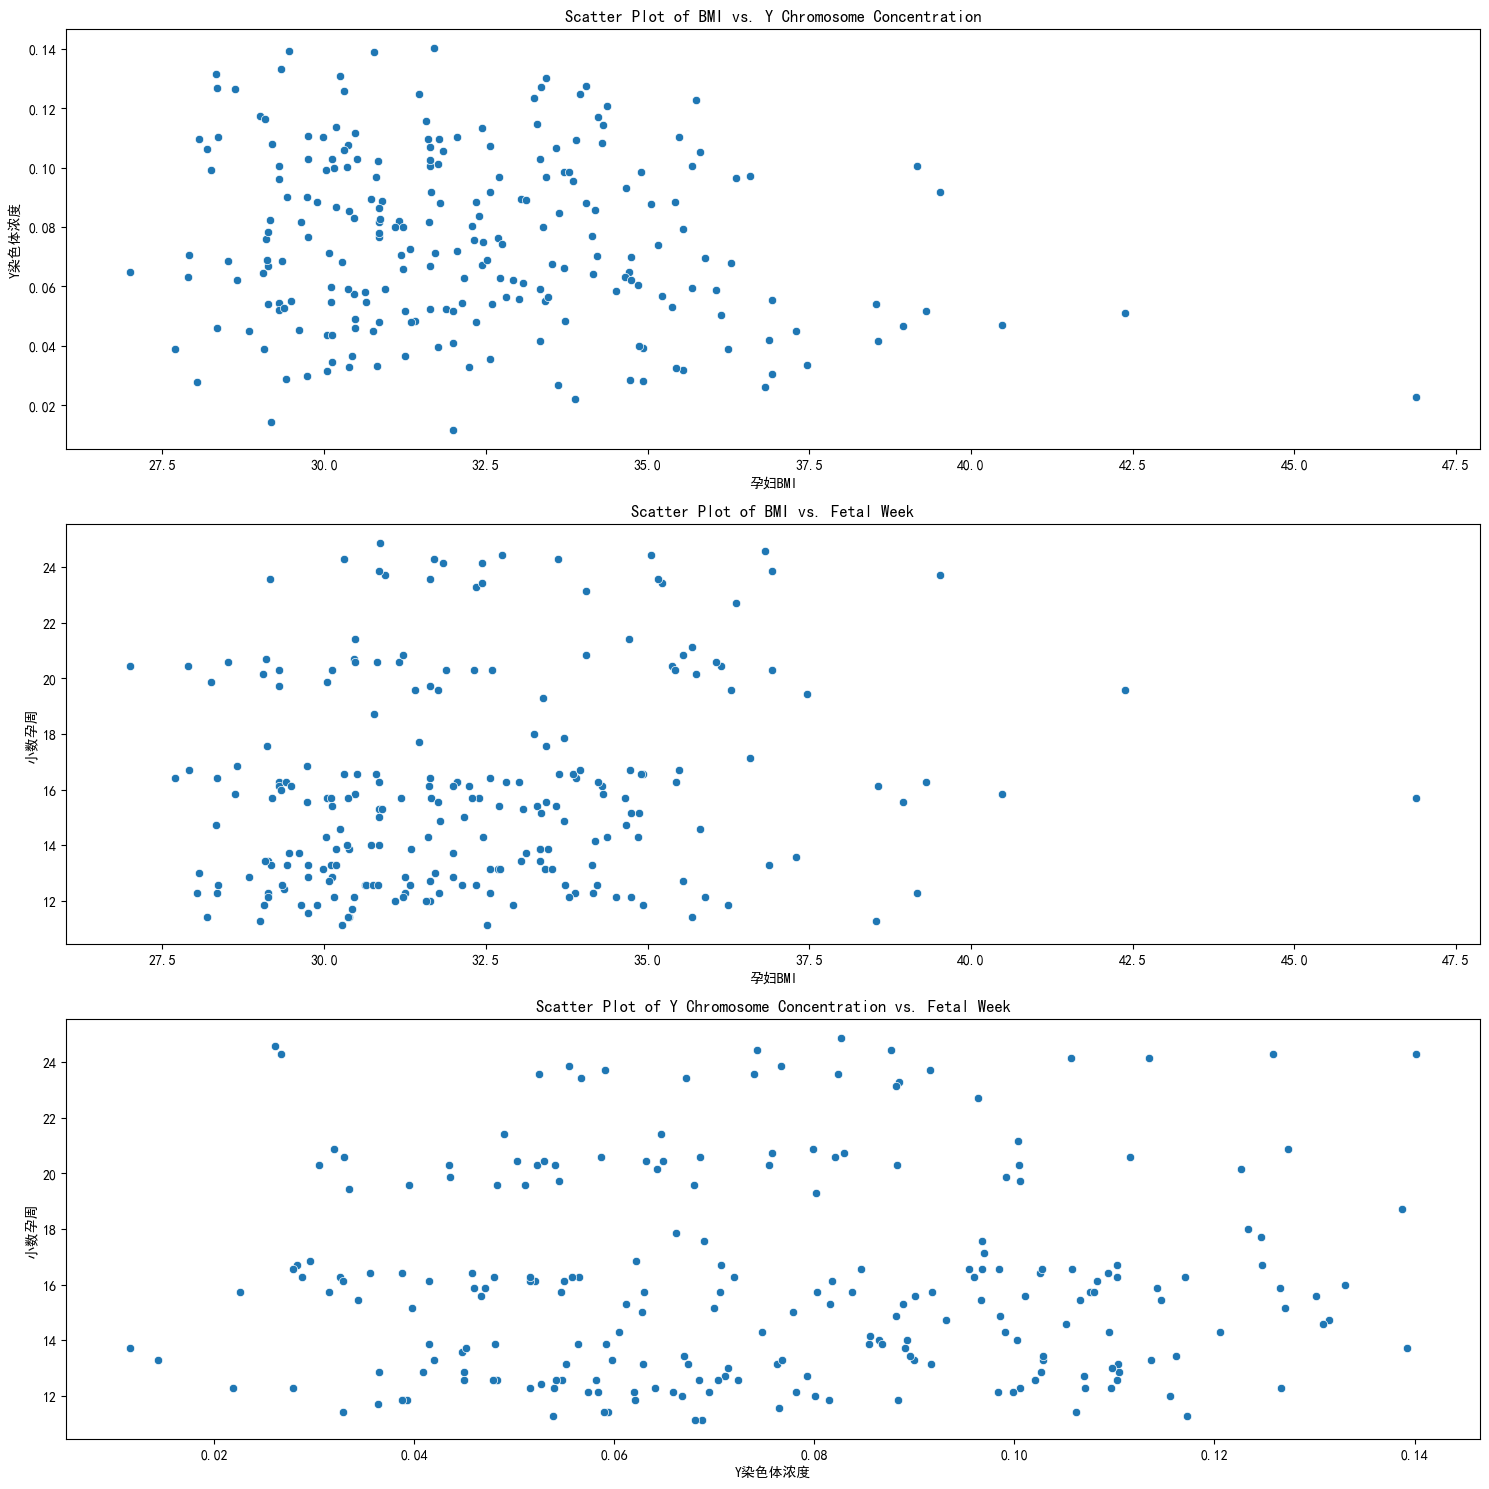

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 设置画布大小
plt.figure(figsize=(15, 15))
# 绘制孕妇BMI vs Y染色体浓度
plt.subplot(3, 1, 1)
sns.scatterplot(x='孕妇BMI', y='Y染色体浓度', data=data)
plt.title('Scatter Plot of BMI vs. Y Chromosome Concentration')
plt.xlabel('孕妇BMI')
plt.ylabel('Y染色体浓度')
# 绘制孕妇BMI vs 小数孕周
plt.subplot(3, 1, 2)
sns.scatterplot(x='孕妇BMI', y='小数孕周', data=data)
plt.title('Scatter Plot of BMI vs. Fetal Week')
plt.xlabel('孕妇BMI')
plt.ylabel('小数孕周')
# 绘制Y染色体浓度 vs 小数孕周
plt.subplot(3, 1, 3)
sns.scatterplot(x='Y染色体浓度', y='小数孕周', data=data)
plt.title('Scatter Plot of Y Chromosome Concentration vs. Fetal Week')
plt.xlabel('Y染色体浓度')
plt.ylabel('小数孕周')
# 调整布局以避免重叠
plt.tight_layout()
# 显示图形
plt.show()

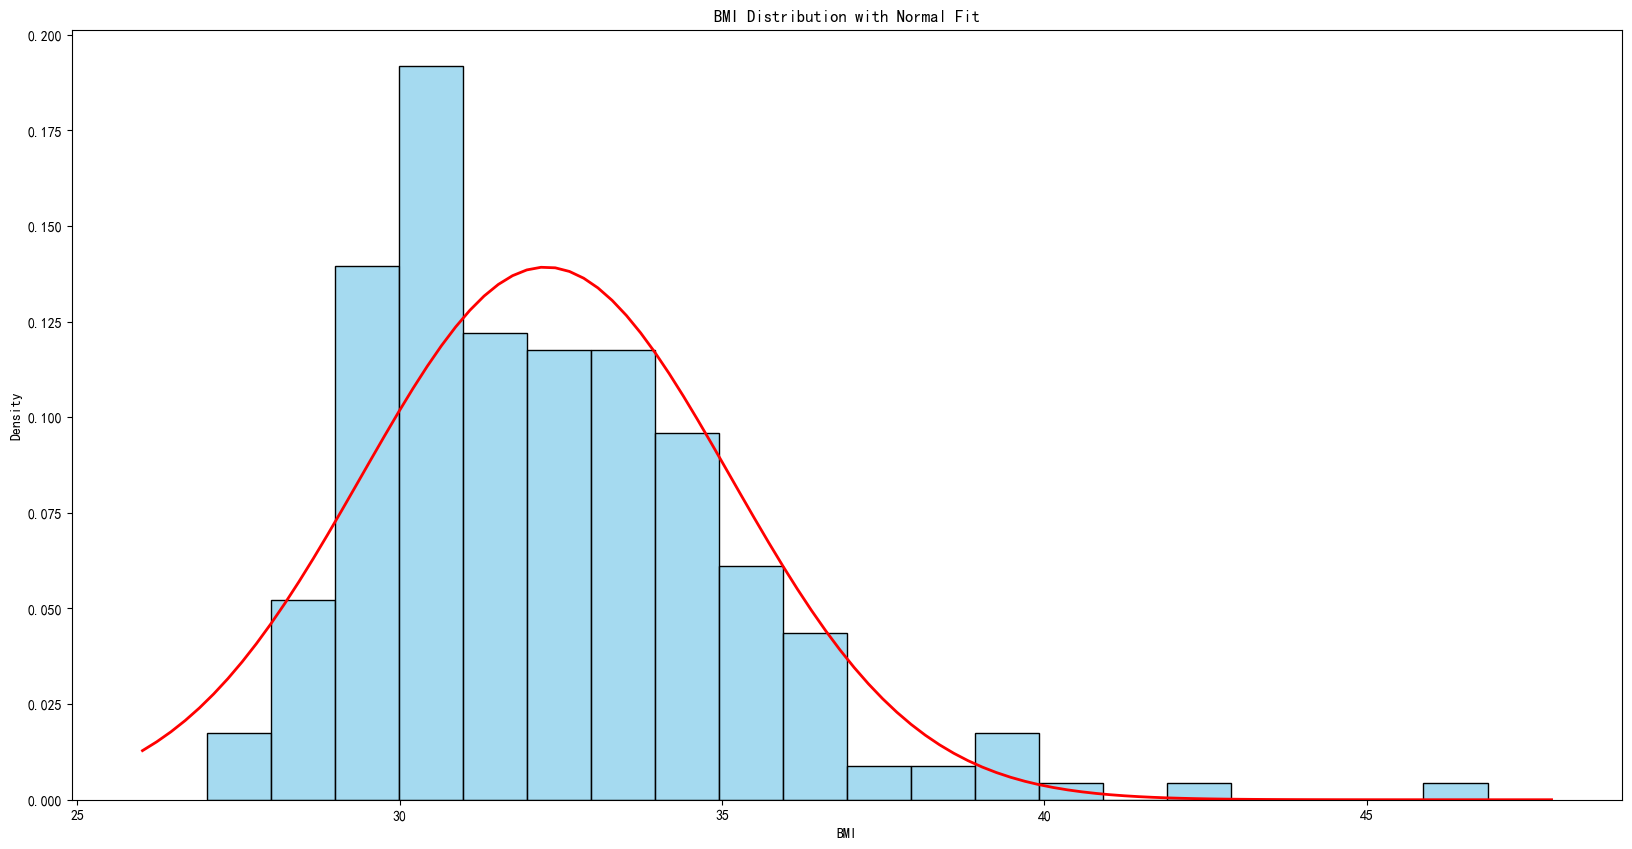

In [96]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
sns.histplot(filtered['孕妇BMI'], bins=20, kde=False, color='skyblue', stat='density', ax=axes)
mu_bmi, std_bmi = stats.norm.fit(filtered['孕妇BMI'])
xmin_bmi, xmax_bmi = axes.get_xlim()
x_bmi = np.linspace(xmin_bmi, xmax_bmi, 100)
p_bmi = stats.norm.pdf(x_bmi, mu_bmi, std_bmi)
axes.plot(x_bmi, p_bmi, 'r', linewidth=2)
axes.set_title('BMI Distribution with Normal Fit')
axes.set_xlabel('BMI')
axes.set_ylabel('Density')
plt.show()

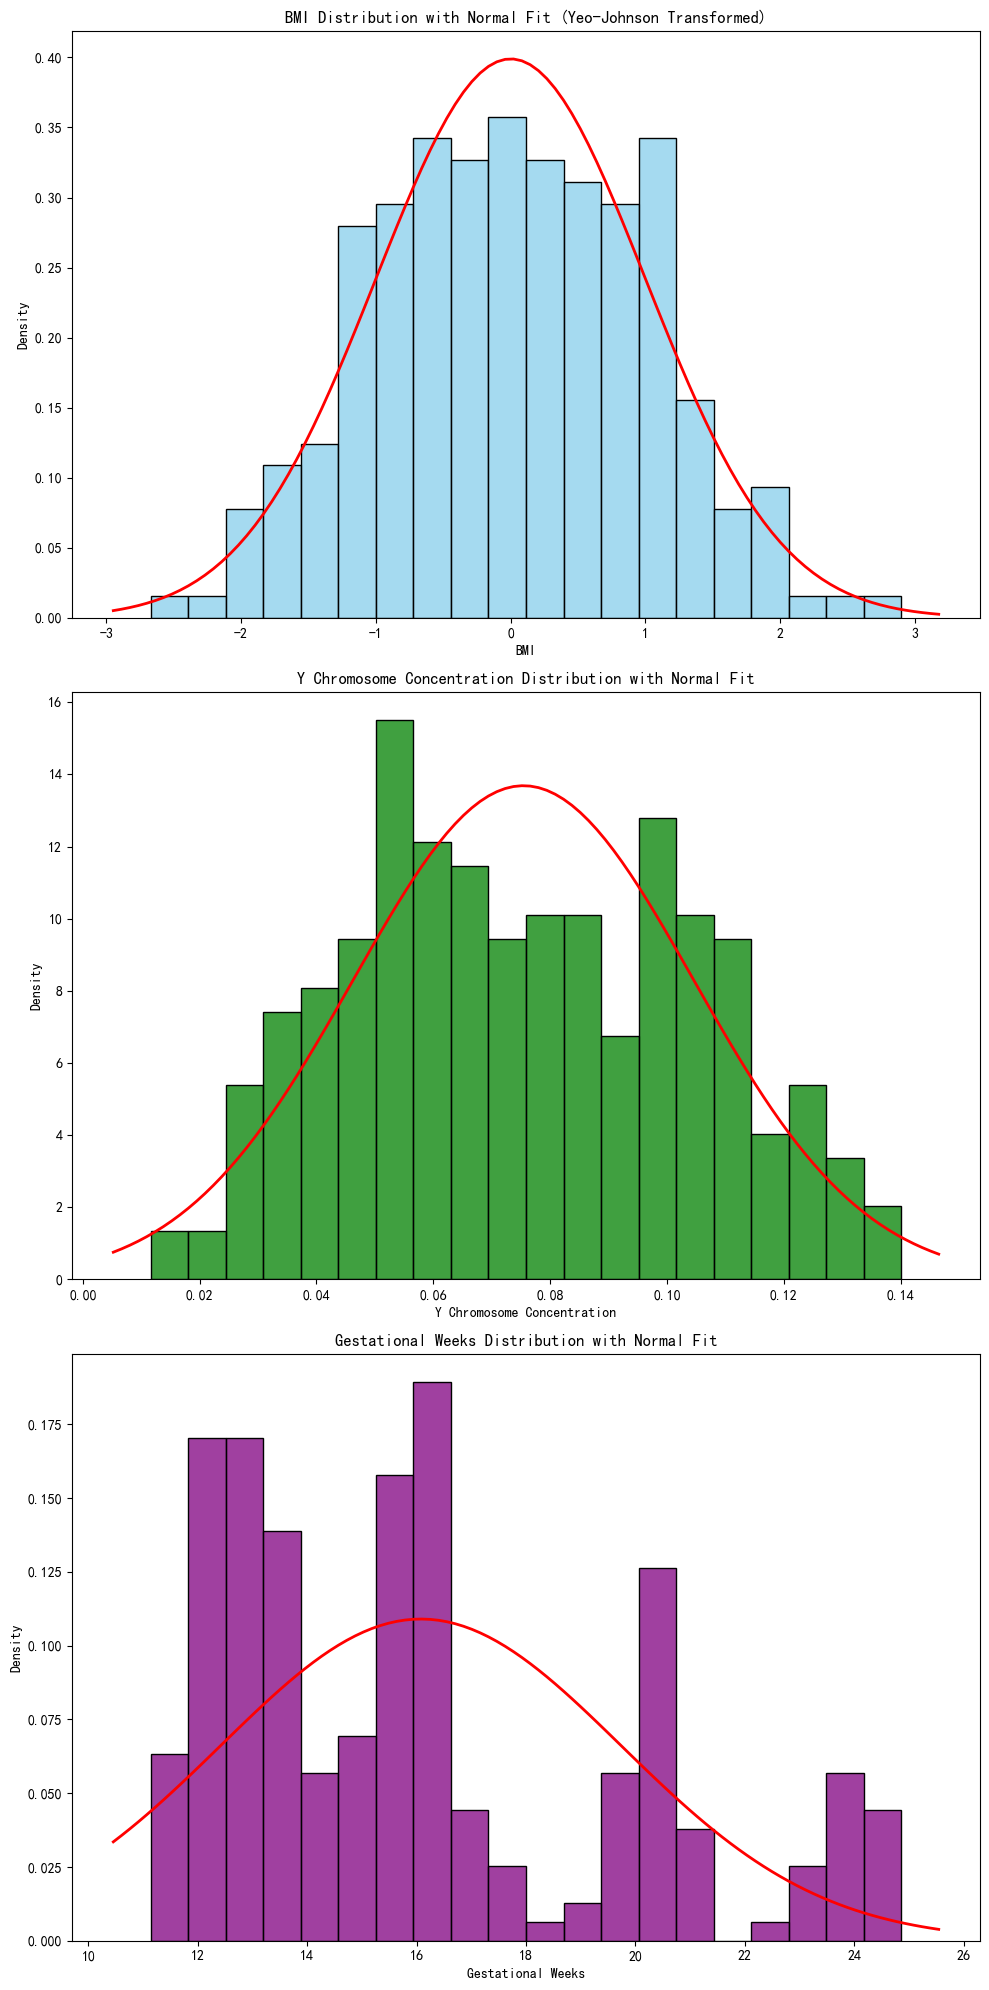

In [97]:
from sklearn.preprocessing import PowerTransformer
# Yeo-Johnson 变换，能够处理负值和零值适合左偏数据
pt = PowerTransformer(method='yeo-johnson')
BMI_data = pt.fit_transform(filtered['孕妇BMI'].values.reshape(-1, 1)).flatten()
fig, axes = plt.subplots(3, 1, figsize=(10, 20))
# 绘制处理后数据的直方图和正态拟合曲线
sns.histplot(BMI_data, bins=20, kde=False, color='skyblue', stat='density', ax=axes[0])
mu_bmi, std_bmi = stats.norm.fit(BMI_data)
xmin_bmi, xmax_bmi = axes[0].get_xlim()
x_bmi = np.linspace(xmin_bmi, xmax_bmi, 100)
p_bmi = stats.norm.pdf(x_bmi, mu_bmi, std_bmi)
axes[0].plot(x_bmi, p_bmi, 'r', linewidth=2)
axes[0].set_title('BMI Distribution with Normal Fit (Yeo-Johnson Transformed)')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Density')

sns.histplot(filtered['Y染色体浓度'], bins=20, kde=False, color='green', stat='density', ax=axes[1])
mu_y, std_y = stats.norm.fit(filtered['Y染色体浓度'])
xmin_y, xmax_y = axes[1].get_xlim()
x_y = np.linspace(xmin_y, xmax_y, 100)
p_y = stats.norm.pdf(x_y, mu_y, std_y)
axes[1].plot(x_y, p_y, 'r', linewidth=2)
axes[1].set_title('Y Chromosome Concentration Distribution with Normal Fit')
axes[1].set_xlabel('Y Chromosome Concentration')
axes[1].set_ylabel('Density')

sns.histplot(filtered['小数孕周'], bins=20, kde=False, color='purple', stat='density', ax=axes[2])
mu_gw, std_gw = stats.norm.fit(filtered['小数孕周'])
xmin_gw, xmax_gw = axes[2].get_xlim()
x_gw = np.linspace(xmin_gw, xmax_gw, 100)
p_gw = stats.norm.pdf(x_gw, mu_gw, std_gw)
axes[2].plot(x_gw, p_gw, 'r', linewidth=2)
axes[2].set_title('Gestational Weeks Distribution with Normal Fit')
axes[2].set_xlabel('Gestational Weeks')
axes[2].set_ylabel('Density')
# 调整子图之间的间距
plt.tight_layout()
plt.show()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     20.3191
Link Function:                     IdentityLink Log Likelihood:                               -130016.1755
Number of Samples:                          231 AIC:                                           260074.9892
                                                AICc:                                          260079.5495
                                                GCV:                                                 0.001
                                                Scale:                                              0.0008
                                                Pseudo R-Squared:                                   0.1394
Feature Function                  Lam

C:\Users\xia\AppData\Local\Temp\ipykernel_40152\2438705890.py:19: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


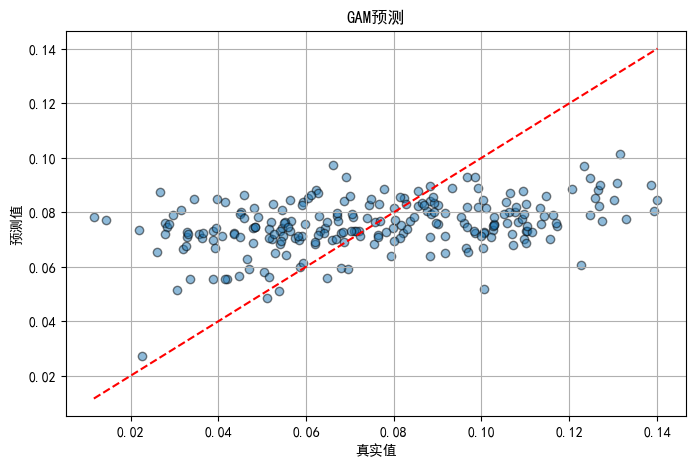

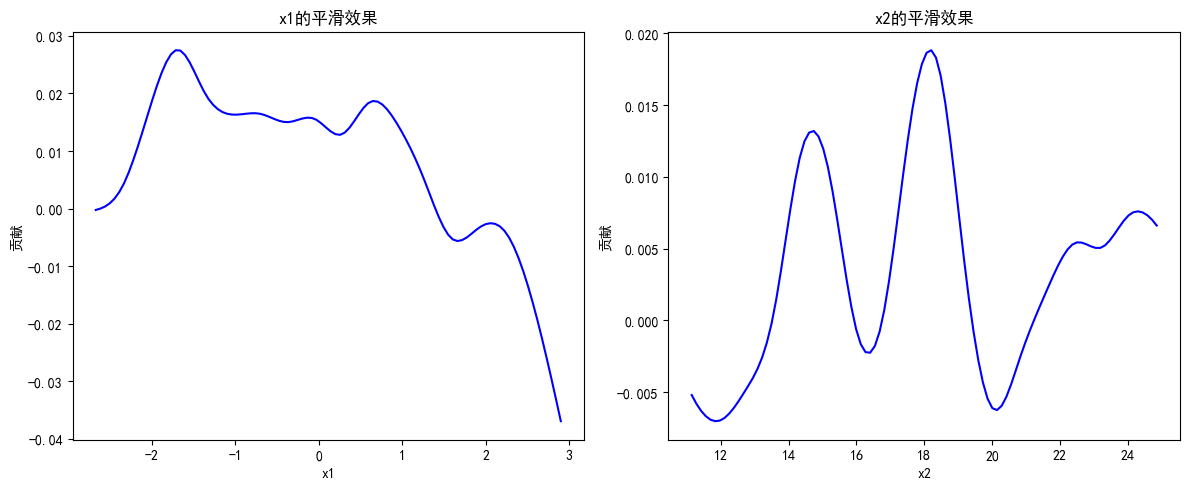

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pygam import LinearGAM, s

# 假定BMI_data和filtered已经定义并包含相应数据
x1 = BMI_data
x2 = filtered['小数孕周']
y = filtered['Y染色体浓度'].values

# 准备数据集
X = np.column_stack((x1, x2))

# 构建GAM模型
gam = LinearGAM(s(0) + s(1))
gam.fit(X, y)

# 打印模型描述及统计信息
print(gam.summary())

# 预测与可视化
y_pred = gam.predict(X)

# 可视化预测结果与真实值关系
plt.figure(figsize=(8, 5))
plt.scatter(y, y_pred, edgecolor='k', alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')
plt.xlabel("真实值")
plt.ylabel("预测值")
plt.title("GAM预测")
plt.grid(True)
plt.show()

# 可视化单一特征的平滑函数效果
plt.figure(figsize=(12, 5))

# 对于x1的部分依赖
plt.subplot(1, 2, 1)
XX = gam.generate_X_grid(term=0)
plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX), 'b-')
plt.title('x1的平滑效果')
plt.xlabel('x1')
plt.ylabel('贡献')

# 对于x2的部分依赖
plt.subplot(1, 2, 2)
XX = gam.generate_X_grid(term=1)
plt.plot(XX[:, 1], gam.partial_dependence(term=1, X=XX), 'b-')
plt.title('x2的平滑效果')
plt.xlabel('x2')
plt.ylabel('贡献')

plt.tight_layout()
plt.show()

